# Optimization with Gradient Descent

[Last time](22-convex-erm.ipynb), we studied the *empirical risk minimization* (ERM). ERM casts the machine learning problem as an optimization problem: we want to find a vector of weights $\mathbf{w}$ such that 

$$
\DeclareMathOperator*{\argmin}{argmin}
\begin{aligned}
\hat{\mathbf{w}} &= \argmin_{\mathbf{w}} L(\mathbf{w}) \\ 
&= \argmin_{\mathbf{w}} \frac{1}{n}\sum_{i = 1}^n \ell(\langle \mathbf{w}, \mathbf{x}_i\rangle, y_i)\;.
\end{aligned}
$${#eq-erm}

As usual, $\mathbf{X} \in \mathbb{R}^{n\times p}$ is the feature matrix

$$
\mathbf{X} = \left[\begin{matrix} & - & \mathbf{x}_1 & - \\ 
& - & \mathbf{x}_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \mathbf{x}_{n} & - \end{matrix}\right] 
$$

and $\mathbf{y}$ is the vector of targets, which we usually assume to be binary in the context of classification. The per-observation *loss function* $\ell: \mathbb{R}\times \mathbb{R}\rightarrow \mathbb{R}$ measures the quality of the score $s_i = \langle \mathbf{w}, \mathbf{x}_i \rangle$ assigned to data point $i$ by comparing it to $y_i$ and outputing a real number $\ell(s_i, y_i)$. 

So, our mathematical task is to find a vector of weights $\mathbf{w}$ that solves @eq-erm. How do we do it? The modern answer is *gradient descent*, and this set of lecture notes is about what that means and why it works. 

## Linear Approximations of Single-Variable Functions

Recall the limit definition of a derivative of a single-variable function. Let $g:\mathbb{R} \rightarrow \mathbb{R}$. The derivative of $g$ at point $w_0$, if it exists, is 

$$
\begin{aligned}
\frac{dg(w_0)}{dw} = \lim_{\delta w\rightarrow 0}\frac{g(w_0 + \delta w) - g(w_0)}{\delta w}\;.
\end{aligned}
$$

If we imagine that $\delta w$ is very small but nonzero, we can interpret this equation a bit loosely as the statement that 

$$
\begin{aligned}
\frac{dg(w_0)}{dw} \approx \frac{g(w_0 + \delta w) - g(w_0)}{\delta w}\;,
\end{aligned}
$$

which upon some algebraic rearrangement says that 

$$
g(w_0 + \delta w) \approx g(w_0) + \frac{dg(w_0)}{dw} \delta w\;.
$$

Taylor's theorem makes this statement precise: 

::: {.callout-note}
::: {#thm-taylor}

## Taylor's Theorem: Univariate Functions

Let $g:\mathbb{R}\rightarrow \mathbb{R}$ be differentiable at point $w_0$. Then, there exists $a > 0$ such that, if $\delta w < a$, then 

$$
g(w_0 + \delta w) = g(w_0) + \frac{dg(w_0)}{dw} \delta w + o(\delta w)\;.
$$

:::
:::

Here, $o(\delta w)$ means "terms that grow small in comparison to $\delta w$ when $\delta w$ itself grows small."

Another common way to write Taylor's theorem is 

$$
g(w) = g(w_0) + \frac{dg(w_0)}{dw} (w - w_0) + o(|w - w_0|)\;,
$$

which comes from substituting $\delta w = t - w_0$. 

Taylor's theorem says that, in a neighborhood of $w_0$, we can approximate $g(w)$ with a linear function. Here's an example of how that looks: 

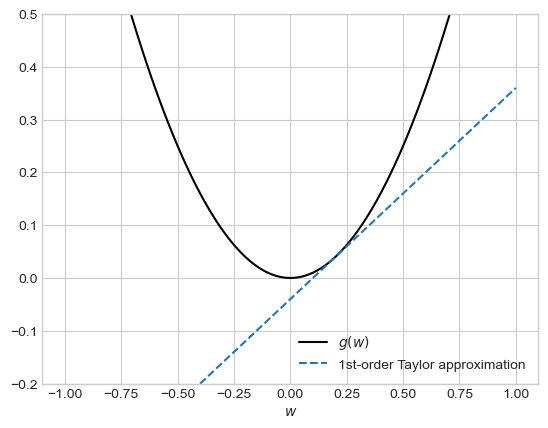

In [1]:
import torch 
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

w = torch.linspace(-1, 1, 101)

g = lambda w: w**2

plt.plot(w, g(w), label = r"$g(w)$", color = "black")
plt.gca().set(xlabel = r"$w$", ylim = (-0.2, 0.5))

#---
def taylor(w, w0):
    return g(w0) + 2*w0*(w-w0)
plt.plot(w, taylor(w, .2), label = r"1st-order Taylor approximation", linestyle = "--")
#---
plt.legend()

## Gradient Descent in 1 dimension

Suppose that we have a function $g$ and we would like to solve the the optimization problem 

$$
\begin{aligned}
\hat{w} = \argmin _w g(w) \;.
\end{aligned}
$$

How do we go about doing this? You might remember from calculus that one way starts with solving the equation 

$$
\begin{aligned}
\frac{dg(\hat{w})}{dw} = 0\;,
\end{aligned}
$$

but it is not always feasible to solve this equation exactly in practice. 

In *iterative* approaches, we instead imagine that we have a current guess $\hat{w}$ which we would like to improve. To this end, consider the casual Taylor approximation [In the rest of these notes, we will assume that term $o(\delta w)$ is small enough to be negligible. ]{.alert}

$$
\begin{aligned}
g(\hat{w} + \delta \hat{w}) \approx g(\hat{w}) + \frac{dg(\hat{w})}{dw} \delta \hat{w}\;.
\end{aligned}
$$

We'd like to update our estimate of $\hat{w}$. Suppose we make a strategic choice: $\delta hat{w} = -\alpha \frac{dg(\hat{w})}{dw}$ for some small $\alpha > 0$. We therefore decide that we will do the update 

$$
\begin{aligned}
    \hat{w} \gets \hat{w} - \alpha \frac{dg(\hat{w})}{dw}\;.
\end{aligned}
$${#eq-w-update}

What does this update do to the value of $g$? Let's check: 

$$
\begin{aligned}
    g(\hat{w} + \delta \hat{w}) &\approx g(\hat{w}) + \frac{dg(\hat{w})}{dw} \delta \hat{w} \\ 
    &= g(\hat{w}) - \frac{dg(\hat{w})}{dw} \alpha \frac{dg(\hat{w})}{dw}\\ 
    &= g(\hat{w}) - \alpha\left(\frac{dg(\hat{w})}{dw}\right)^2\;.   
\end{aligned}
$$

This is the big punchline. Let's look at the second term. If $\left(\frac{dg(\hat{w})}{dw}\right)^2 = 0$ then that must mean that $\frac{dg(\hat{w})}{dw}$ and that we are at a critical point, which we could check for being a local minimum. On the other hand, if $\frac{dg(\hat{w})}{dw} \neq 0$, then $\left(\frac{dg(\hat{w})}{dw}\right)^2 > 0$. This means that 

$$
\begin{aligned}
g(\hat{w} + \delta \hat{w}) &\approx  g(\hat{w}) - \alpha\left(\frac{dg(\hat{w})}{dw}\right)^2 \\ 
                            &<  g(\hat{w})\;,
\end{aligned}
$$

provided that $\alpha$ is small enough for the error terms in Taylor's Theorem to be small. We have informally derived the following fact: 

::: {.callout-tip}

## Single-Variable Gradient-Descent Works

Let $g:\mathbb{R}\rightarrow \mathbb{R}$ be differentiable and assume that $\frac{dg(\hat{w})}{dw} \neq 0$. Then, if $\alpha$ is sufficiently small, @eq-w-update is guaranteed to reduce the value of $g$. 

:::

Let's see an example of single-variable gradient descent in action: 

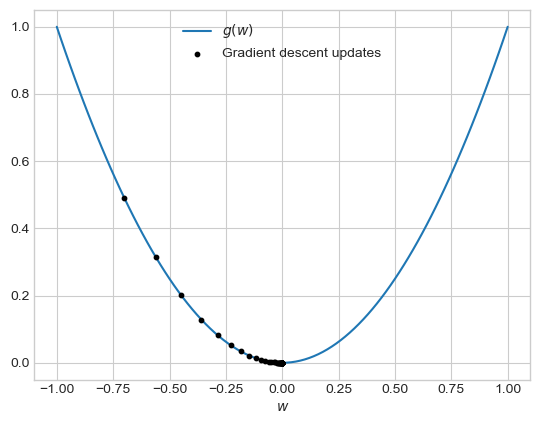

In [2]:
w_     = -0.7
grad  = lambda w: 2*w
alpha = 0.1
w_vec = [w_]

for i in range(100):
    #---
    w_ = w_ - alpha*grad(w_) 
    #---
    w_vec.append(w_)

w_vec = torch.tensor(w_vec)

plt.plot(w, g(w), label = r"$g(w)$")
plt.scatter(w_vec, g(w_vec), color = "black", label = r"Gradient descent updates", s = 10, zorder = 10)
plt.gca().set(xlabel = r"$w$")
plt.legend()

We can see the updates from gradient descent eventually converging to the point $w = 0$, which is the global minimum of this function. 


## Gradient Descent in Multiple Dimensions

Our empirical risk function $L$ is not a single-variable function; indeed, $L: \mathbb{R}^p \rightarrow \mathbb{R}$. So, we can't directly apply the results above. Fortunately, these results extend in a smooth way to this setting. The main thing we need is the definition of the *gradient* of a multivariate function. 

## Gradients

[We're not going to talk much about what it means for a function to be multivariate differentiable. You can assume that all the functions we will deal with in this class are unless I highlight otherwise. For a more rigorous definition, you should check out a multivariable calculus class.]{.aside}

::: {.callout-note}
::: {#def-gradient}

## Gradient of a Multivariate Function

Let $g:\mathbb{R}^p \rightarrow \mathbb{R}$ be a *multivariate differentiable* function. The *gradient* of $g$ evaluated at point $\mathbf{w}\in \mathbb{R}^p$ is written $\nabla g(\mathbf{w})$, and has value 

$$
\nabla g(\mathbf{w}) \triangleq 
\left(\begin{matrix}
    \frac{\partial g(\mathbf{w})}{\partial w_1} \\ 
    \frac{\partial g(\mathbf{w})}{\partial w_2} \\ 
    \cdots \\ 
    \frac{\partial g(\mathbf{w})}{\partial w_p} \\ 
\end{matrix}\right) \in \mathbb{R}^p\;.
$$

Here, $\frac{\partial g(\mathbf{w})}{\partial w_1}$ is the *partial derivative of $f$ with respect to $z_1$, evaluated at $\mathbf{w}$*. To compute it: 

> Take the derivative of $f$ *with respect to variable $z_1$, holding all other variables constant, and then evaluate the result at $\mathbf{w}$. 

:::
:::

::: {.callout-tip}

## Example

Let $p = 3$. Let $g(\mathbf{w}) = w_2\sin w_1  + w_1e^{2w_3}$. The partial derivatives we need are 

$$
\begin{align}
\frac{\partial g(\mathbf{w})}{\partial w_1} &= w_2 \cos w_1 + e^{2w_3}\\ 
\frac{\partial g(\mathbf{w})}{\partial w_2} &= \sin w_1\\ 
\frac{\partial g(\mathbf{w})}{\partial w_3} &= 2w_1 e^{2w_3}\;. 
\end{align}
$$

So, the gradient of $g$ evaluated at a point $\mathbf{w}$ is 

$$
\nabla g(\mathbf{w}) =
\left(\begin{matrix}
    \frac{\partial g(\mathbf{w})}{\partial w_1} \\ 
    \frac{\partial g(\mathbf{w})}{\partial w_2} \\ 
    \frac{\partial g(\mathbf{w})}{\partial w_3} \\ 
\end{matrix}\right) = 
\left(\begin{matrix}
    w_2 \cos w_1 + e^{2w_3}\\
    \sin w_1\\ 
    2w_1 e^{2w_3}
\end{matrix}\right) 
$$

:::

Taylor's Theorem extends smoothly to this setting. 


::: {.callout-note}
::: {#thm-taylor}

## Taylor's Theorem: Multivariate Functions

Let $g:\mathbb{R}^p\rightarrow \mathbb{R}$ be differentiable at point $\mathbf{w}_0 \in \mathbb{R}^p$. Then, there exists $a > 0$ such that, if $\lVert \delta \mathbf{w} \rVert < a$, then [$\lVert \mathbf{\delta} \mathbf{w}\rVert \triangleq \sqrt{\sum_{i = 1}^p (\delta w_i)^2}$]{.aside}

$$
g(\mathbf{w}_0 + \delta \mathbf{w}) = g(\mathbf{w}_0) + \langle \nabla g(\mathbf{w}_0), \delta \mathbf{w} \rangle + o(\lVert \delta \mathbf{w}\rVert)\;.
$$

:::
:::

The vector $\nabla g(\mathbf{w}_0)$ plays the role of the single-variable derivative $\frac{d g(w_0)}{dw}$. 

### Multivariate Gradient Descent 

In multiple dimensions, the gradient descent update is: 

$$
\begin{aligned}
    \hat{\mathbf{w}} \gets \hat{\mathbf{w}} - \alpha \nabla g(\hat{\mathbf{w}})\;.
\end{aligned}
$${#eq-gradient-descent-multi}

Let's check that a single update of gradient descent will reduce the value of $g$ provided that $\alpha$ is small enough. Here, $\delta \hat{\mathbf{w}} = -\alpha \nabla g(\hat{\mathbf{w}})$.

$$
\begin{aligned}
    g(\hat{\mathbf{w}} - \delta \hat{\mathbf{w}}) &\approx g(\hat{\mathbf{w}}) + \langle \nabla g(\mathbf{w}_0), \delta \mathbf{w} \rangle \\ 
    &= g(\hat{\mathbf{w}}) + \langle \nabla g(\hat{\mathbf{w}}), -\alpha \nabla g(\hat{\mathbf{w}}) \rangle \\ 
    &= g(\hat{\mathbf{w}}) - \alpha \langle \nabla g(\hat{\mathbf{w}}),  \nabla g(\hat{\mathbf{w}}) \rangle \\ 
    &= g(\hat{\mathbf{w}}) - \alpha \lVert\nabla g(\hat{\mathbf{w}}) \rVert^2\;. 
\end{aligned}
$$

Since $\lVert\nabla g(\hat{\mathbf{w}}) \rVert^2 > 0$ whenever $\nabla g(\hat{\mathbf{w}}) \neq\mathbf{0}$, we conclude that, unless $\hat{w}$ is a critical point (where the gradient is zero), then 

$$
\begin{aligned}
    g(\hat{\mathbf{w}} - \alpha \nabla g(\hat{\mathbf{w}})) < g(\hat{\mathbf{w}})\;. 
\end{aligned}
$$

In other words, provided that $\alpha$ is small enough for the Taylor approximation to be a good one, multivariate gradient descent also always reduces the value of the objective function. 




## Gradient of the Empirical Risk

Remember that our big objective here was to solve @eq-erm using gradient descent. To do this, we need to be able to calculate $\nabla L(\mathbf{w})$, where the gradient is with respect to the entries of $\mathbf{w}$. Fortunately, the specific *linear* structure of the score function $s_i = \langle \mathbf{w}, \mathbf{x}_i \rangle$ makes this relatively simple: indeed, we actually only need to worry about the *single* variable derivatives of the per-observation loss $\ell$. To see this, we can compute

$$
\begin{align}
\nabla L(\mathbf{w}) &= \nabla \left(\frac{1}{n} \sum_{i = 1}^n \ell(\langle \mathbf{w}, \mathbf{x}_i\rangle , y_i)\right) \\ 
              &= \frac{1}{n} \sum_{i = 1}^n \nabla \ell(\langle \mathbf{w}, \mathbf{x}_i\rangle , y_i) \\ 
              &= \frac{1}{n} \sum_{i = 1}^n  \frac{d\ell(s_i, y_i)}{ds} \nabla \langle \mathbf{w}, \mathbf{x}_i\rangle  &\quad \text{(multivariate chain rule)} \\ 
              &= \frac{1}{n} \sum_{i = 1}^n  \frac{d\ell(s_i, y_i)}{ds}  \mathbf{x}_i &\quad \text{(gradient of a linear function)} \\ 
              &= \frac{1}{n} \sum_{i = 1}^n  \frac{d\ell(s_i, y_i)}{ds} \mathbf{x}_i &\quad \text{($s_i = \langle \mathbf{w}, \mathbf{x}_i\rangle$)} \\ 
\end{align}
$$

The good news here is that for linear models, we don't actually need to be able to compute more gradients: we just need to be able to compute derivatives of the form $\frac{d\ell(s_i, y_i)}{ds}$ and then plug in $s_i = \langle \mathbf{w}, \mathbf{x}_i\rangle$. 

Let's do an example with the logistic loss: 

$$\ell(s, y) = -y \log \sigma(s) - (1-y)\log (1-\sigma(s))\;.$$

A useful fact to know about the logistic sigmoid function $\sigma$ is that $\frac{d\sigma(s) }{ds} = \sigma(s) (1 - \sigma(s))$. So, using that and the chain rule, the derivative we need is 

$$
\begin{align}
\frac{d\ell(s, y)}{ds} &= -y \frac{1}{\sigma(s)}\frac{d\sigma(s) }{ds} - (1-y)\frac{1}{1-\sigma(s)}\left(- \frac{d\sigma(s) }{ds}\right) \\ 
&= -y \frac{1}{\sigma(s)}\sigma(s) (1 - \sigma(s)) - (1-y)\frac{1}{1-\sigma(s)}\left(- \sigma(s) (1 - \sigma(s))\right) \\ 
&= -y (1 - \sigma(s)) + (1-y)\sigma(s) \\ 
&= \sigma(s) - y\;.
\end{align}
$$

Finally, we need to plug this back in to our empirical risk, obtaining the gradient of the empirical risk for logistic regression: 

[An important note about this formula that can easily trip one up: this looks a bit like a matrix multiplication or dot product, but it isn't! ]{.aside}
$$
\begin{align}
\nabla L(\mathbf{w}) &= \frac{1}{n} \sum_{i = 1}^n (\sigma(s_i) - y_i)\mathbf{x}_i \\ 
              &=\frac{1}{n} \sum_{i = 1}^n (\sigma(\langle \mathbf{w}, \mathbf{x}_i\rangle) - y_i)\mathbf{x}_i\;.
\end{align}
$${#eq-logistic-gradient}

This gives us all the math that we need in order to learn logistic regression by choosing a learning rate and iterating the update $\mathbf{w}^{(t+1)} \gets \mathbf{w}^{(t)} - \alpha \nabla L(\mathbf{w}^{(t)})$ until convergence. 

## Example: Logistic Regression


This model *also* inherits from the `LinearModel` class that you previously started implementing. The training loop is also *very* similar to our training loop for the perceptron. The main difference is that the loss is calculated using the `binary_cross_entropy` function above, and the `step` function of the `GradientDescentOptimizer` works differently in a way that we will discuss in the following section. 

*Starting with the code block below, you won't be able to follow along in coding these notes unless you have sneakily implemented logistic regression in a `hidden` module.*


In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

The logistic regression training loop relies on a new implementation of `opt.step`. For gradient descent, here's the complete implementation: just a quick Python version of the gradient descent update @eq-gradient-descent-multi. 

In [4]:
def step(self, X, y, lr = 0.01):
    self.model.w -= lr*self.model.grad(X, y)

The method `model.grad()` is the challenging part of the implementation: this is where we actually need to turn @eq-logistic-gradient into code. 

Here's the complete training loop. This loop is *very* similar to our perceptron training loop -- we're just using a different loss and a different implementation of `grad`. 

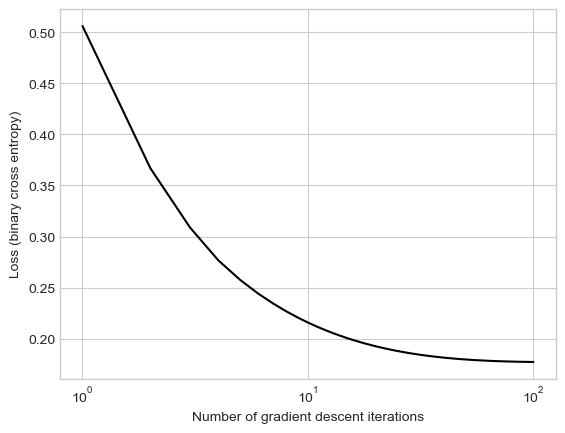

In [5]:
#| fig-cap: 'Evolution of the binary cross entropy loss function in the logistic regression training loop.'
#| fig-cap-location: margin
#| label: fig-LR-loss-iterations

from hidden.logistic import LogisticRegression, GradientDescentOptimizer

# instantiate a model and an optimizer
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

# for keeping track of loss values
loss_vec = []

for _ in range(100):

    # not part of the update: just for tracking our progress    
    loss = LR.loss(X, y) 
    loss_vec.append(loss)

    # only this line actually changes the parameter value
    # The whole definition is: 
    # self.model.w -= lr*self.model.grad(X, y)

    opt.step(X, y, lr = 0.02)

plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

The loss quickly levels out to a constant value, which is our optimized weight vector $\mathbf{w}$. Because our theory tells us that the loss function is convex, we know that the value of $\mathbf{w}$ we have found is the best possible, in the sense of minimizing the loss. 

Let's check our training accuracy: 

In [6]:
(1.0*(LR.predict(X) == y)).mean()

tensor(0.9167)

Not too bad! 

## Recap 

In these lecture notes, we introduced *gradient descent* as a method for minimizing functions, and showed an application of gradient descent for logistic regression. Gradient descent is especially useful when working with convex functions, since in this case it is guaranteed to converge to the global minimum of the empirical risk (provided that the learning rate $\alpha$ is sufficiently low). The idea of gradient descent -- incremental improvement to the weight vector $\mathbf{w}$ using information about the derivatives of the loss function--is a fundamental one which has led to many variations and improvements. 